# Global 
Imports, Constants, Utils, etc..



## GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 14:09:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 33%   34C    P8    19W / 170W |    878MiB / 12045MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
  using_clab = True
except:
  using_clab = False

In [3]:
import os
import sys
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torch.utils.data as t_data

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer


## Constant definision

In [30]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)



MAGNOMETER_SENSORS = [ "magnetometer_magnetic_field_body_x",
                      "magnetometer_magnetic_field_body_y", 
                      "magnetometer_magnetic_field_body_z"]
BOROMETER_SENSORS = ["barometer_altitude", "barometer_pressure"]
ROTOR_SPEEDS = ["rotor_a_speed", "rotor_b_speed", "rotor_c_speed", "rotor_d_speed"]
ACCELOMETER_SENSORS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                       "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                       "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                       "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]

ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
ANGULAR_VELOCITY_SENSORS = ["angular_velocity_x", "angular_velocity_y"]
LINEAR_ACCELERATION_SENSORS = ["linear_acceleration_x", "linear_acceleration_y"]
ANGULAR_ACCELERATION_SENSORS = [ "angular_acceleration_x", "angular_acceleration_y"]

INPUT_SEQUENCE_COLUMNS = [*ORIENTATION_SENSORS, *LINEAR_ACCELERATION_SENSORS]

OUTPUT_SEQUENCE_COLUMNS = ["linear_velocity_x", "linear_velocity_y"]

# MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 30

In [46]:
def get_recordings_files(data_dir: str = DATA_FOLDER_PATH):
    all_csv_files = os.listdir(data_dir)
    all_csv_files.remove("manual_2022:04:22_20:38:48_record.csv")
    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    # auto_genereted_flights = [recording_file for recording_file in all_csv_files 
    #                           if not recording_file.startswith("manual")]
    # manual_generated_flights = [recording_file for recording_file in all_csv_files 
    #                           if recording_file.startswith("manual")]

    # all_csv_files = []
    # all_csv_files.extend(auto_genereted_flights)
    # all_csv_files.extend(manual_generated_flights)

    return all_csv_files


## Utils


###General

In [6]:
def get_feature_indexes(features: list):
  """
  Returns indexes of the input feature in the dataset
  """
  return [INPUT_SEQUENCE_COLUMNS.index(feature) for feature in features]

### Save and Load models

In [7]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

### Data Split

In [8]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [9]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data 

In [10]:
def _to_steps(df: pd.DataFrame, columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = df[columns].shift(-1)
    diff_df = (next_time_df - df[columns]) 
    df.loc[:, columns] = diff_df
    return df

In [11]:
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    next_df = x_df[ORIENTATION_SENSORS].shift(-1)
    orientaion_diff = (next_df - x_df[ORIENTATION_SENSORS])
    orientaion_diff.rename(columns={key : f"{key}_diff" for key in orientaion_diff.columns}, inplace=True)

    y_df = flight_df[output_columns].copy()

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    x_df = pd.concat([x_df, orientaion_diff[:-1]], axis=1)

    return x_df, y_df

In [12]:

def load_dataset_short_sequences(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df.to_numpy())
            y_sessions.append(y_df.to_numpy())
        except ValueError as error:
            print(str(error))

    all_x_sequences = []
    all_y_sequences = []

    # splits all data into sequences of INPUT_SEQUENCE_LENGTH  length
    for x_session, y_session in zip(x_sessions, y_sessions):
      samples_amount =  y_session.shape[0]
      for index in range(0, 
                         samples_amount - INPUT_SEQUENCE_LENGTH,
                         INPUT_SEQUENCE_LENGTH):
        all_x_sequences.append(x_session[index: index+ INPUT_SEQUENCE_LENGTH, :])
        all_y_sequences.append(y_session[index: index+ INPUT_SEQUENCE_LENGTH, :])

    x_data = np.stack(all_x_sequences)
    y_data = np.stack(all_y_sequences)

    return x_data, y_data

In [13]:

def load_dataset_long_sequences(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df.to_numpy())
            y_sessions.append(y_df.to_numpy())
        except ValueError as error:
            print(str(error))

   
    # Chooses the sequence size to train on
    sequence_size = int(np.mean(np.array([len(recording) for recording in x_sessions])))
    print(f"Padds input data to {sequence_size} length")

    padded_x_sessions = pad_sequences(x_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float32')
    padded_y_sessions = pad_sequences(y_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float32')
    
    x_data = np.stack(padded_x_sessions)
    y_data = np.stack(padded_y_sessions)

    return x_data, y_data

### Preprocesses data


In [14]:
def preprocess_dataset(x_data, y_data):
    scaler_x = MinMaxScaler((-1,1))
    scaler_y = MinMaxScaler()

    reshaped_x = x_data.reshape(-1, x_data.shape[-1])
    reshaped_y = y_data.reshape(-1, y_data.shape[-1])

    x_data = scaler_x.fit_transform(reshaped_x).reshape(x_data.shape)
    y_data = scaler_y.fit_transform(reshaped_y).reshape(y_data.shape)

    return x_data, y_data, scaler_x, scaler_y

In [15]:
def load_preprocessed_sequence_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset_short_sequences(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_dataset(x_data, y_data)
    
    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)
    
    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

# Feature Analysis

## Visualization

In [ ]:
record_file_name = "recording_30Jan_22:08_4_record.csv"      
record_file_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
x_df, y_df = load_flight_steps_from_file(record_file_path, 
                                         INPUT_SEQUENCE_COLUMNS,
                                         OUTPUT_SEQUENCE_COLUMNS)

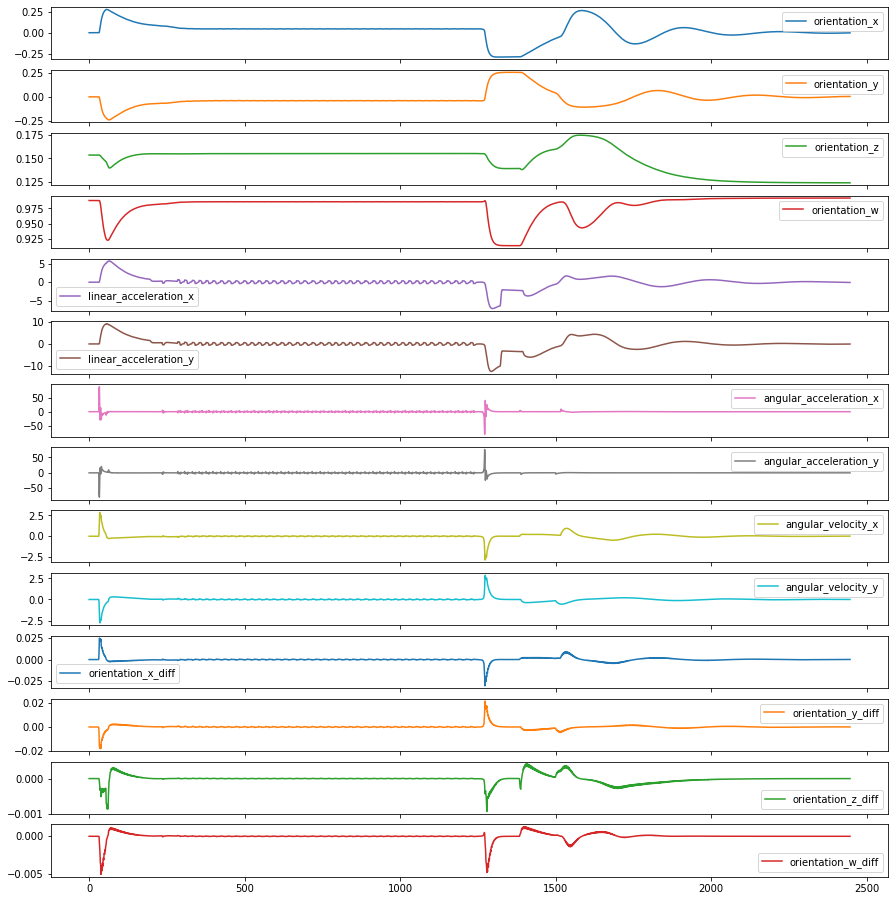

In [ ]:
otuput = x_df.plot(subplots=True, figsize=(15,16))

###### Plot

All Columns plot


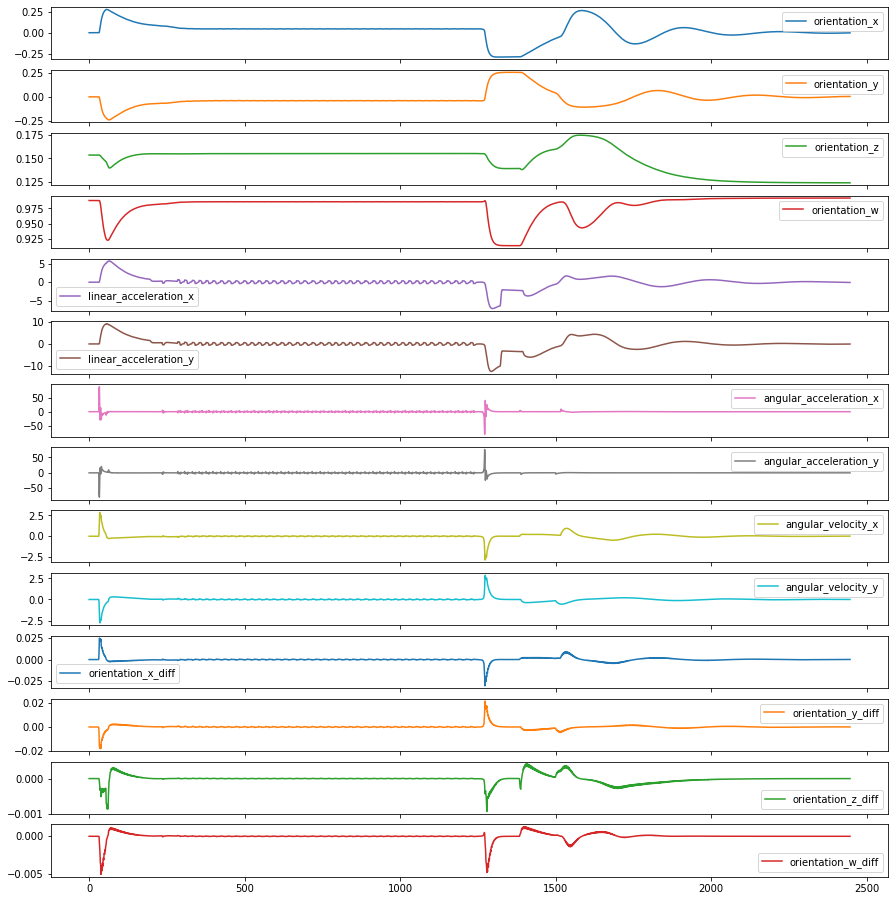

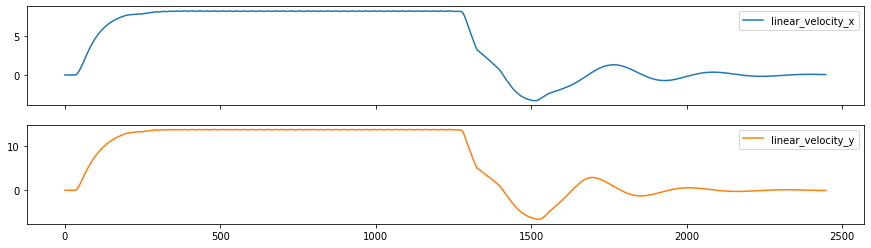

In [ ]:
print("All Columns plot")
otuput = x_df.plot(subplots=True, figsize=(15,16))
otuput = y_df.plot(subplots=True, figsize=(15,4))

###### Hist

All Columns plot


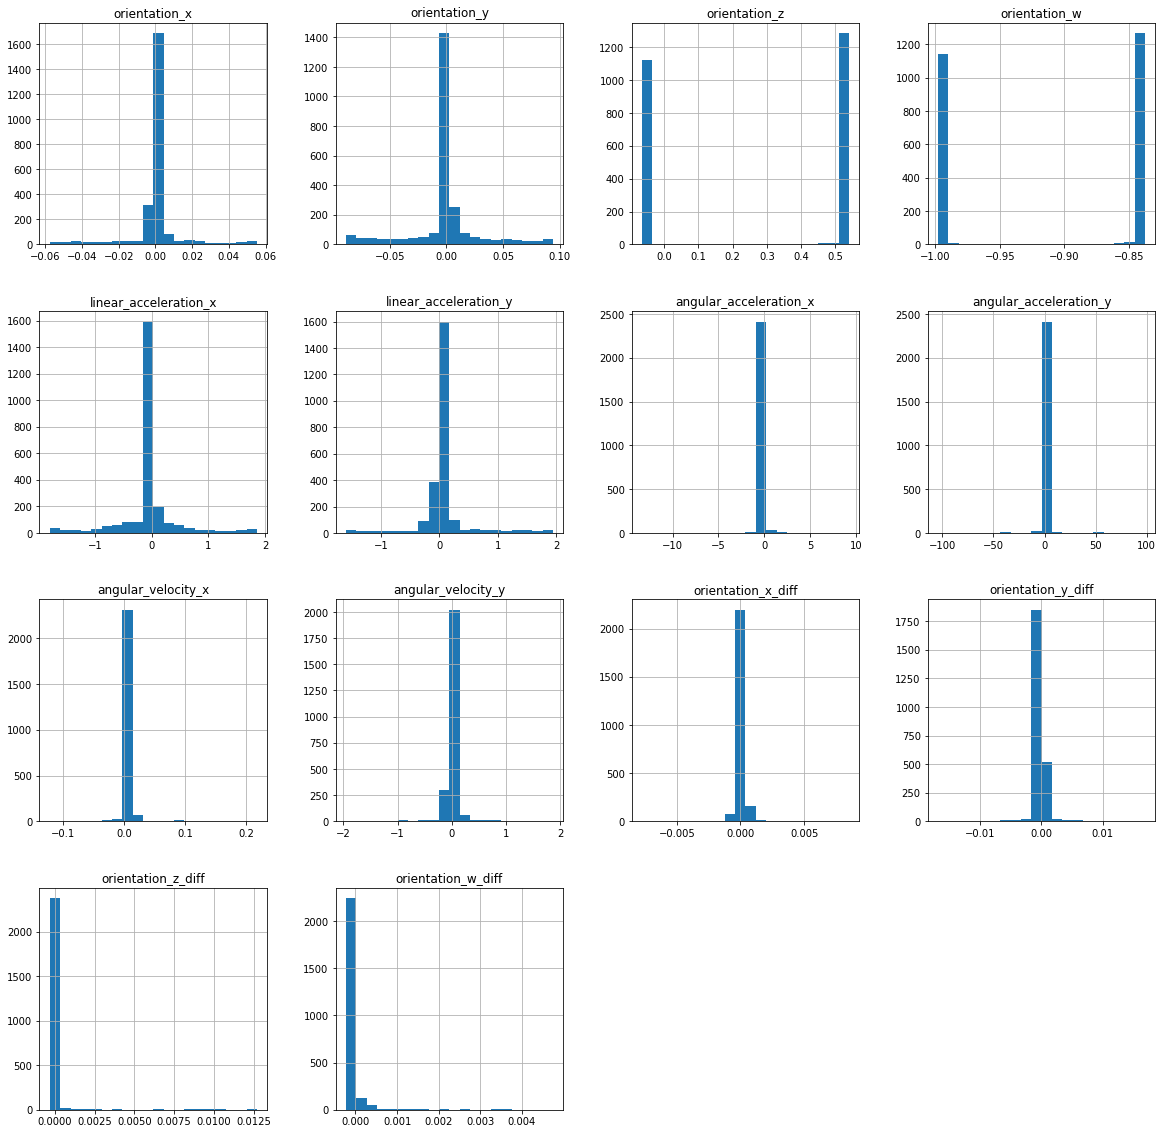

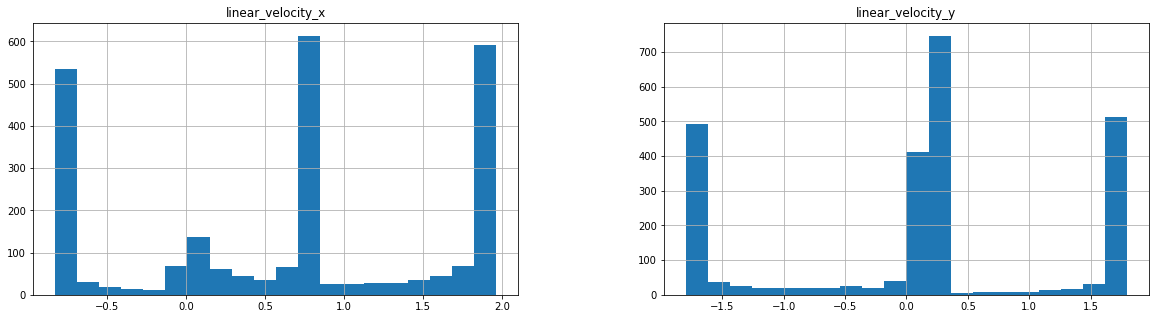

In [ ]:
print("All Columns plot")
otuput = x_df.hist(figsize=(20,20), bins=20)
otuput = y_df.hist(figsize=(20,5), bins=20)

#Model Creation & Tranining

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Model definition

In [63]:
# class SpeedLSTM(nn.Module):

#     def __init__(self, hidden_dim: int, ann_pre_amount: int, ann_post_amount: int):
#         super(SpeedLSTM, self).__init__()
        
#         self.input_size = len(INPUT_SEQUENCE_COLUMNS)  + len(ORIENTATION_SENSORS)
#         self.nn_pre = torch.nn.Linear(self.input_size, ann_pre_amount)
#         self.lstm_input_size = ann_pre_amount  + len(OUTPUT_SEQUENCE_COLUMNS)

#         self.hidden_dim = hidden_dim
#         self.lstm_cell = nn.LSTMCell(self.lstm_input_size, self.hidden_dim)
#         self.nn_post = torch.nn.Linear(self.hidden_dim, ann_post_amount)
#         self.output = torch.nn.Linear(ann_post_amount, len(OUTPUT_SEQUENCE_COLUMNS))

#     def forward(self, input_batch, initial_speed):
#         saved_output = initial_speed
#         output = []

#         after_first = F.tanh(self.nn_pre(input_batch))

#         for seq_id in range(input_batch.shape[1]):
#           curr_seq = after_first[:, seq_id, :]
#           new_x = torch.hstack((curr_seq, saved_output))
#           h0, _ = self.lstm_cell(new_x)
#           new_x = F.relu(self.nn_post(h0))
#           new_x = self.output(new_x)

#           saved_output = new_x
#           output.append(new_x)

#         return torch.stack(output, dim=1)

In [67]:
class SpeedLSTM(nn.Module):

    def __init__(self, hidden_dim: int, ann_amount: int):
        super(SpeedLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.input_size = len(INPUT_SEQUENCE_COLUMNS) + len(OUTPUT_SEQUENCE_COLUMNS) + len(ORIENTATION_SENSORS)

        self.lstm_cell = nn.LSTMCell(self.input_size, self.hidden_dim)
        self.nn1 = torch.nn.Linear(self.hidden_dim, ann_amount)
        self.output = torch.nn.Linear(ann_amount, len(OUTPUT_SEQUENCE_COLUMNS))

    def forward(self, input_batch, initial_speed):
        saved_output = initial_speed
        output = []
        for seq_id in range(input_batch.shape[1]):
          curr_seq = input_batch[:, seq_id, :]
          new_x = torch.hstack((curr_seq, saved_output))
          h0, _ = self.lstm_cell(new_x)
          new_x = F.relu(self.nn1(h0))
          new_x = self.output(new_x)

          saved_output = new_x
          output.append(new_x)

        return torch.stack(output, dim=1)

## Model Tranining

In [68]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_sequence_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

if using_clab:
  train_x = torch.cuda.FloatTensor (train_x)
  train_y = torch.cuda.FloatTensor(train_y)
  dev_x = torch.cuda.FloatTensor(dev_x)
  dev_y = torch.cuda.FloatTensor(dev_y)
else:
  train_x = torch.Tensor(train_x)
  train_y = torch.Tensor(train_y)
  dev_x = torch.Tensor(dev_x)
  dev_y = torch.Tensor(dev_y)





In [70]:
epoches = 300
batch_size = 128

epoch: 0 train_loss: 0.34934775908788046, validation_loss: 3.202011283901003, validation_epprox_error: 0.0
epoch: 1 train_loss: 0.3272481175263723, validation_loss: 2.9989095909727945, validation_epprox_error: 0.0
epoch: 2 train_loss: 0.3038850776354472, validation_loss: 2.78427478339937, validation_epprox_error: 0.0
epoch: 3 train_loss: 0.2772982289393743, validation_loss: 2.537124445041021, validation_epprox_error: 0.0
epoch: 4 train_loss: 0.24930481493473053, validation_loss: 2.278511264257961, validation_epprox_error: 0.0
epoch: 5 train_loss: 0.22086788098017374, validation_loss: 2.0144229564401837, validation_epprox_error: 0.0
epoch: 6 train_loss: 0.19126408954461416, validation_loss: 1.742468923330307, validation_epprox_error: 0.0
epoch: 7 train_loss: 0.1589455799261729, validation_loss: 1.4449068365825548, validation_epprox_error: 0.0
epoch: 8 train_loss: 0.12606549382209778, validation_loss: 1.1415464787019625, validation_epprox_error: 0.0
epoch: 9 train_loss: 0.097912655075391

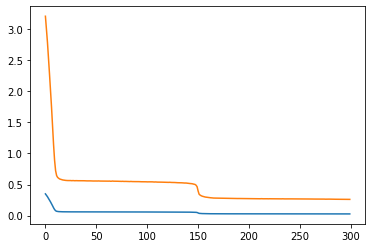

In [74]:
model = SpeedLSTM(hidden_dim=64 , ann_amount=32)

if using_clab:
  model.to(device)
  pin_memory=False
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000051)
# scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200, 250 , 300, 350, 400, 500, 550], gamma=0.5)

o2s_train_dataset = t_data.TensorDataset(train_x, train_y)
train_dataloader = t_data.DataLoader(o2s_train_dataset, batch_size=batch_size, shuffle=True)

o2s_valid_dataset = t_data.TensorDataset(dev_x, dev_y)
valid_dataloader = t_data.DataLoader(o2s_valid_dataset, batch_size=batch_size, shuffle=True)


history_loss = {"train": [], "validation": []}
for epoch_index in range(epoches):  
    total_epoch_loss =  0

    # Tranining
    for batch_x, batch_y in train_dataloader:

        batch_y_init = batch_y[:,0,:]
        model.zero_grad()

        pred_speed = model(batch_x, batch_y_init)

        loss = criterion(pred_speed, batch_y)
        total_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    # scheduler.step()

    epoch_train_loss = total_epoch_loss / len(train_dataloader)
    history_loss["train"].append(epoch_train_loss)
    total_batch_loss = 0
    total_approx_error_matric = 0

    # Validation
    for batch_x, batch_y in valid_dataloader:
      batch_y_init = batch_y[:,0,:].clone()

      pred_speed = model(batch_x, batch_y_init)

      loss = criterion(pred_speed, batch_y)
      total_epoch_loss += loss.item()

      # # Calculating approximation error matric
      # pred_y = pred_speed.detach().numpy()
      # pred_y = scaler_y.inverse_transform(pred_y.reshape(-1, len(OUTPUT_SEQUENCE_COLUMNS))).reshape(pred_y.shape)
      # real_y = batch_y.detach().numpy()
      # real_y = scaler_y.inverse_transform(real_y.reshape(-1, len(OUTPUT_SEQUENCE_COLUMNS))).reshape(real_y.shape)

      # pred_y = np.round(pred_y, decimals=3)
      # real_y = np.round(real_y, decimals=3)
      # divide_real_y = real_y.copy()
      # divide_real_y[divide_real_y == 0]  =  1

      # approximation_error = (100 * (np.absolute(real_y - pred_y) / np.absolute(divide_real_y)).mean(axis=0))[0]
      # total_approx_error_matric += approximation_error

    approx_error =   total_approx_error_matric / len(valid_dataloader)
    epoch_valid_loss = total_epoch_loss / len(valid_dataloader)
    history_loss["validation"].append(epoch_valid_loss)

    print(f"epoch: {epoch_index} train_loss: {epoch_train_loss}, validation_loss: {epoch_valid_loss}, validation_epprox_error: {approx_error}")


loss = history_loss["train"]
val_loss = history_loss["validation"]

plt.plot(loss)
plt.plot(val_loss)
plt.show()

## Loss graph

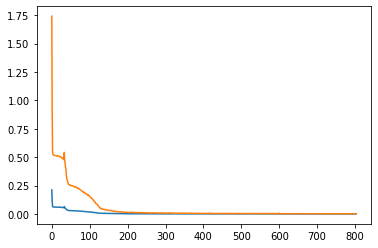

In [56]:
loss = history_loss["train"]
val_loss = history_loss["validation"]

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
dev_x.shape

torch.Size([1074, 30, 10])

## Save model

In [ ]:
model_name = "s2s_o2s_20seq_3"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

# Model Testing 

In [57]:
def plot_model_prediction(real_xy_speed, pred_xy_speed):
    approximation_error = (100 * (np.absolute(pred_xy_speed - real_xy_speed) / np.absolute(pred_xy_speed)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 0].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 1].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 1].reshape(-1, 1))

    plt.show()

In [58]:
def test_lstm_model_predictions(model,
                               scaler_x: MinMaxScaler,
                               scaler_y: MinMaxScaler, 
                               record_file_name: str):
    recording_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
    x_df, y_df = load_flight_steps_from_file(recording_path,
                                             INPUT_SEQUENCE_COLUMNS,
                                             OUTPUT_SEQUENCE_COLUMNS)
    data_x = x_df.to_numpy()
    real_xy_speed = y_df.to_numpy()

    noramlized_real_x = scaler_x.transform(data_x)
    normalized_real_x = np.expand_dims(noramlized_real_x, axis=0)

    if using_clab:
      normalized_real_x = torch.cuda.FloatTensor(normalized_real_x)
    else:
      normalized_real_x = torch.Tensor(normalized_real_x)

    initial_xy_speed = y_df.iloc[0].to_numpy().reshape(1, -1)
    initial_xy_speed = scaler_y.transform(initial_xy_speed)

    if using_clab:
      initial_xy_speed = torch.cuda.FloatTensor(initial_xy_speed)
    else:
      initial_xy_speed = torch.Tensor(initial_xy_speed)
      
    predicted_sequence = model(normalized_real_x, initial_xy_speed)

    if using_clab:
      predicted_sequence = predicted_sequence.cpu()
      
    predicted_sequence = predicted_sequence.detach().numpy()
    pred_xy_speed = scaler_y.inverse_transform(predicted_sequence[0])
      
    plot_model_prediction(real_xy_speed, pred_xy_speed)          

In [66]:
model_name = "s2s_o2s_30seq_2"
model, scaler_x, scaler_y = load_model_with_scalers_binary(model_name)
model

SpeedLSTM(
  (lstm_cell): LSTMCell(12, 64)
  (nn1): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
)

approximation_error: 393.1405176131906


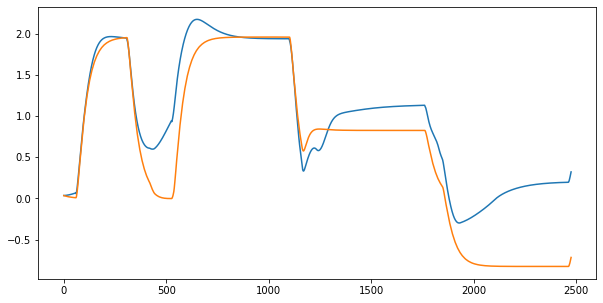

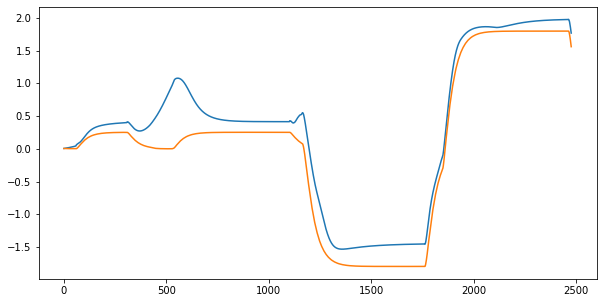

In [62]:
record_file_name = "manual_2022:04:22_20:38:48_record.csv"   
test_lstm_model_predictions(model, scaler_x, scaler_y, record_file_name)   

approximation_error: 824.766828358152


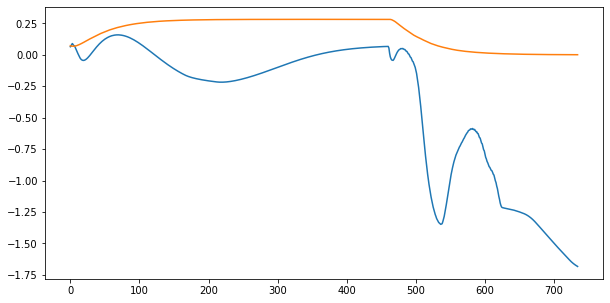

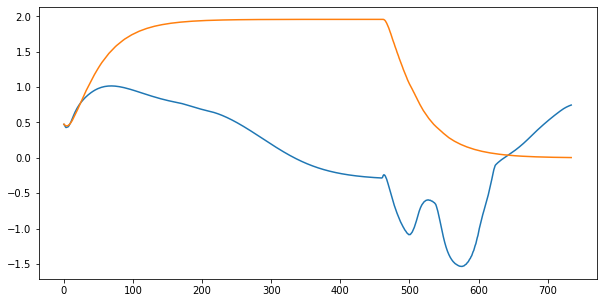

approximation_error: 47.16071062326296


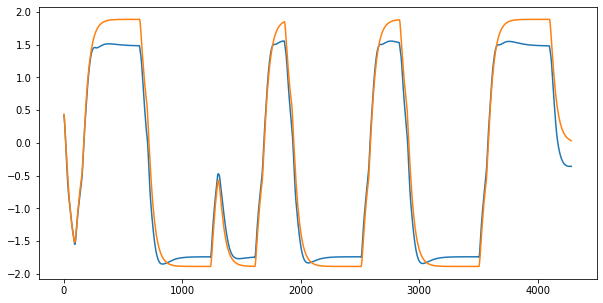

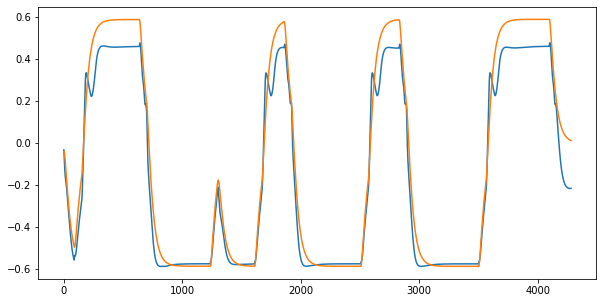

approximation_error: 192.8717544339841


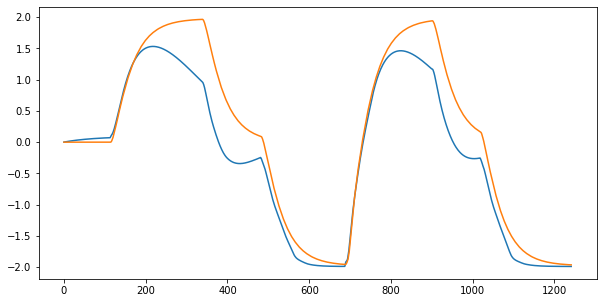

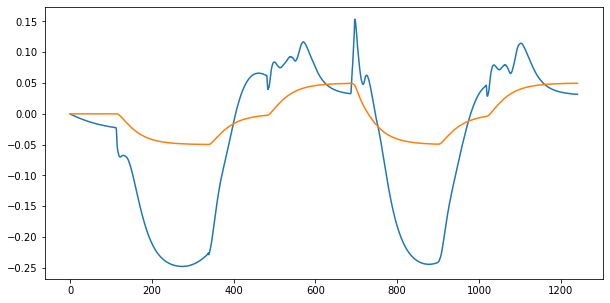

approximation_error: 474.08649214116065


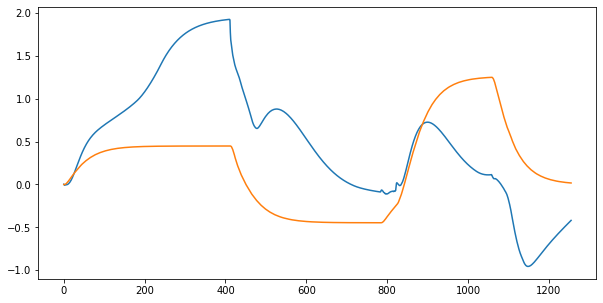

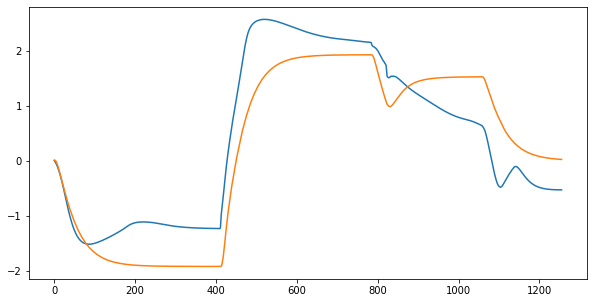

approximation_error: 686.7288461190805


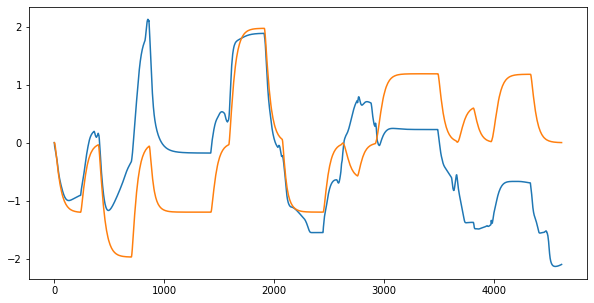

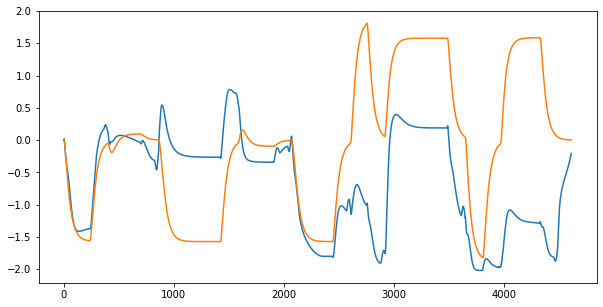

approximation_error: 44.63216621923387


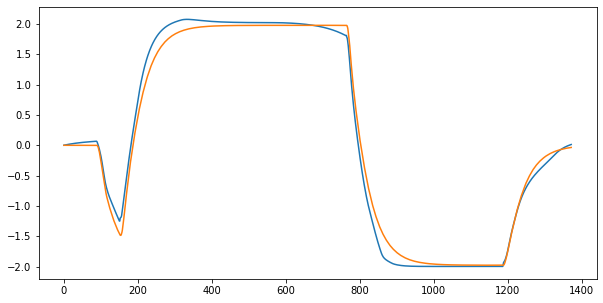

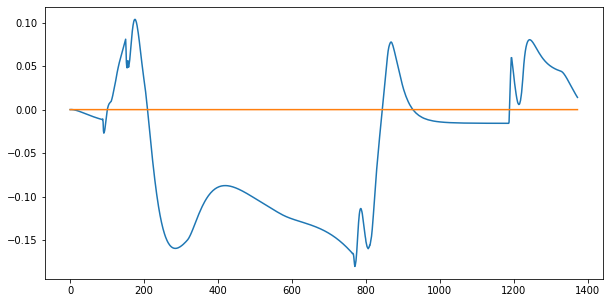

approximation_error: 38.89899855760316


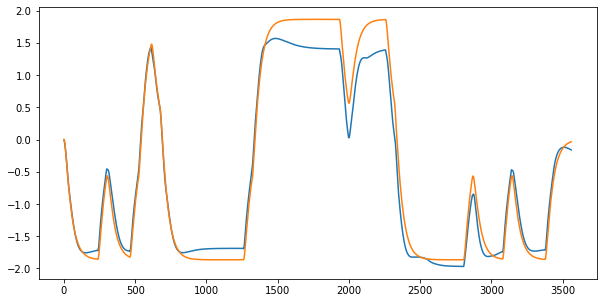

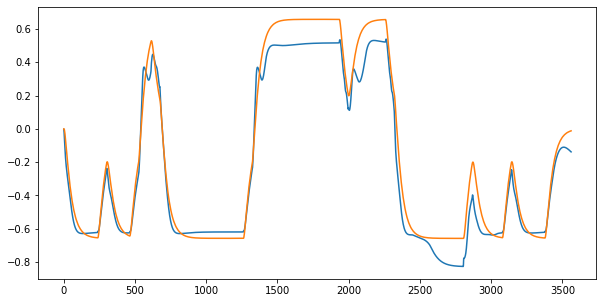

approximation_error: 234.51917673987896


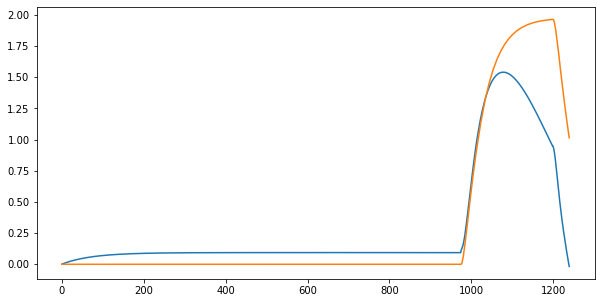

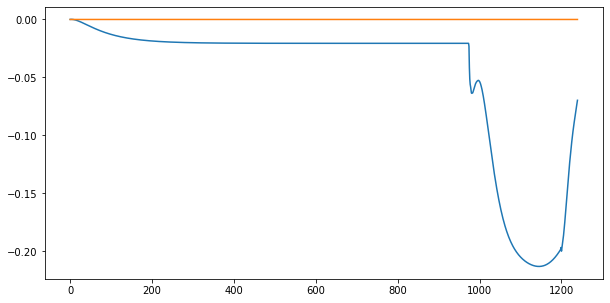

approximation_error: 25641.872258828436


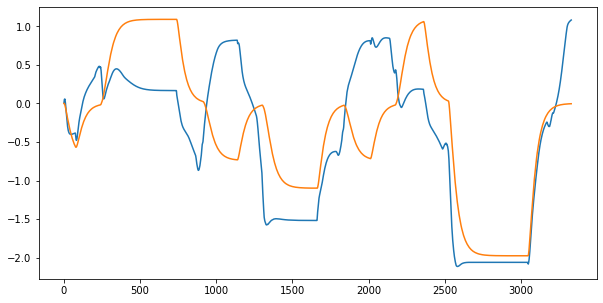

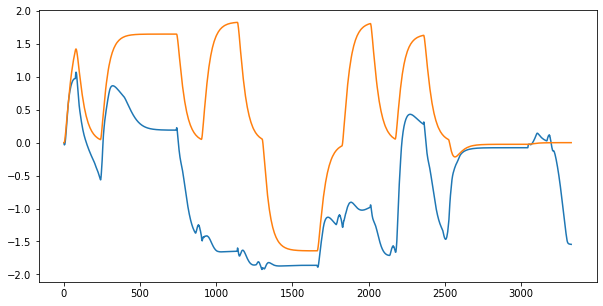

approximation_error: 78.93828532659148


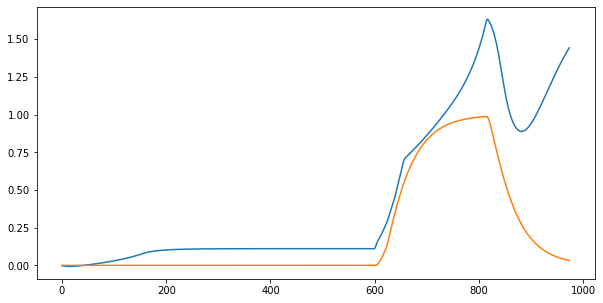

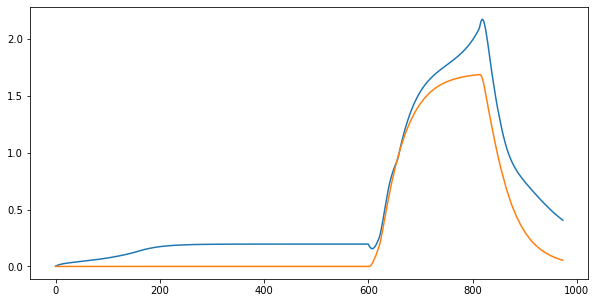

approximation_error: 209.7906901250492


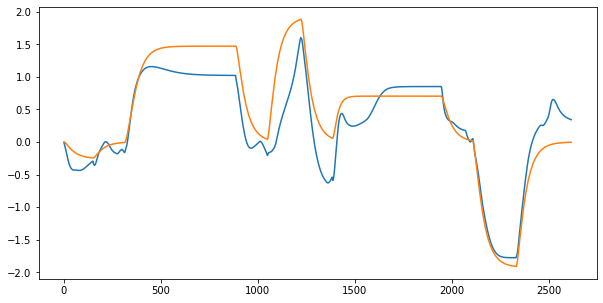

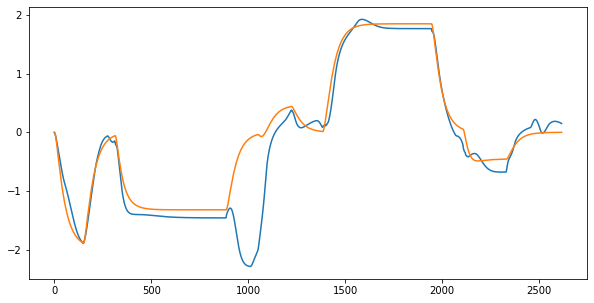

approximation_error: 879.1734323811347


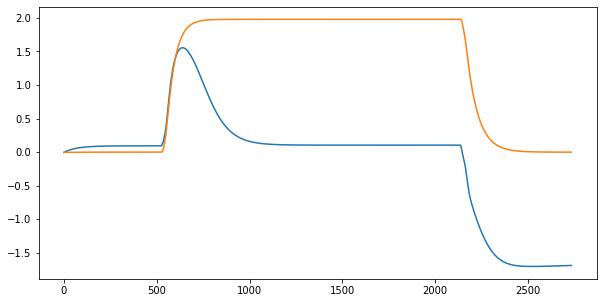

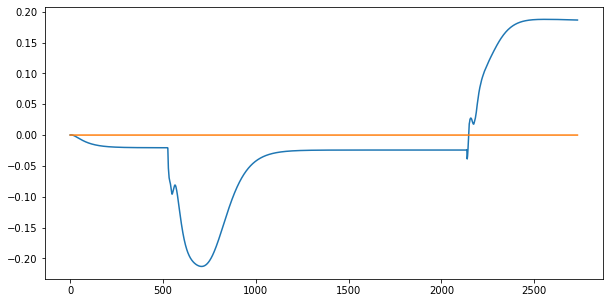

approximation_error: 140.1232110485894


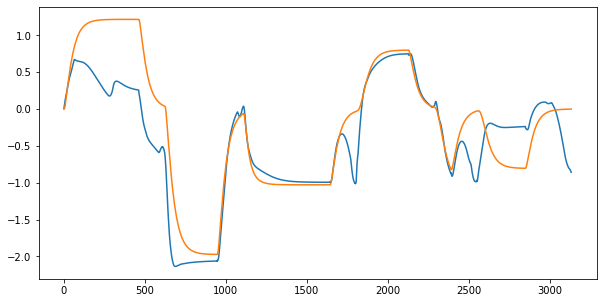

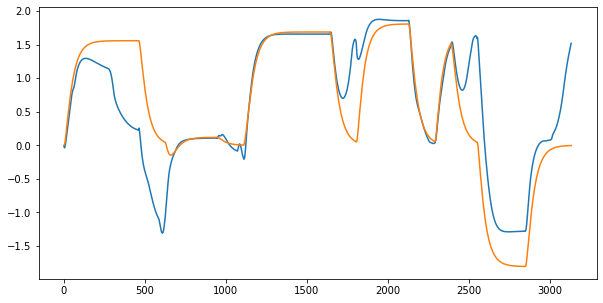

approximation_error: 194.14029123392996


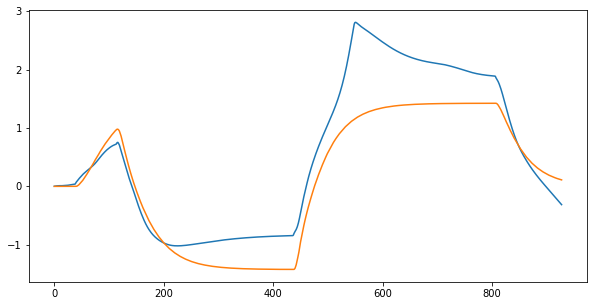

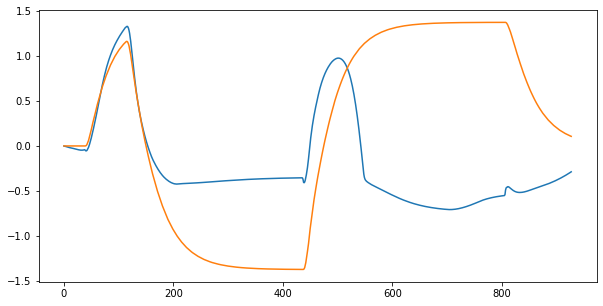

approximation_error: 292.6686026524287


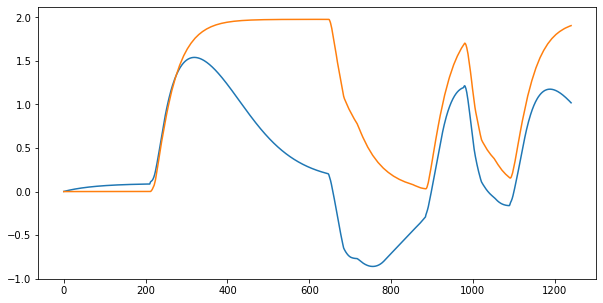

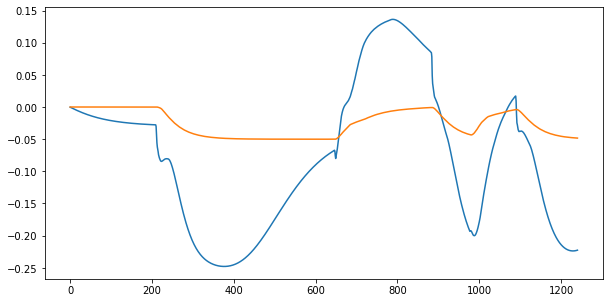

approximation_error: 136.90257948080614


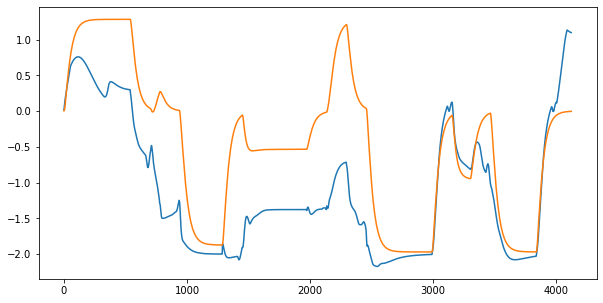

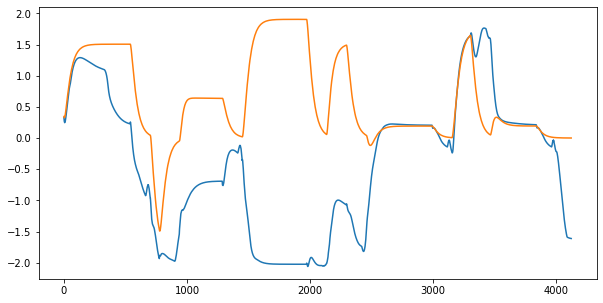

approximation_error: 168.76789357819152


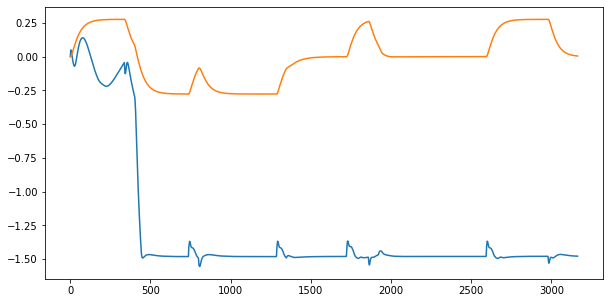

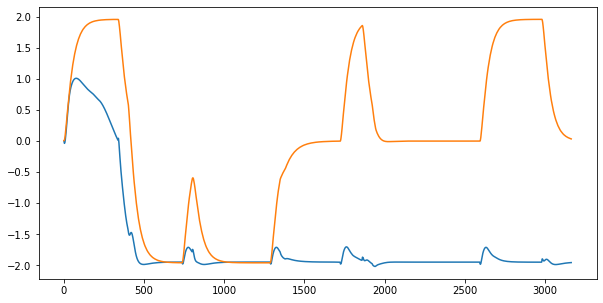

approximation_error: 177.157917364635


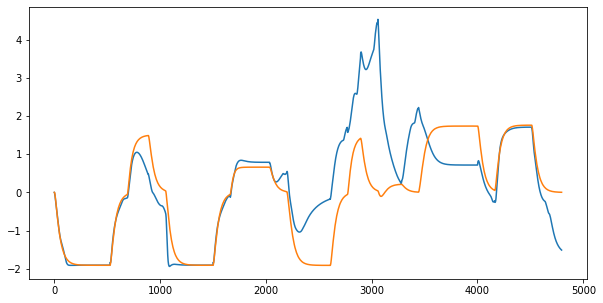

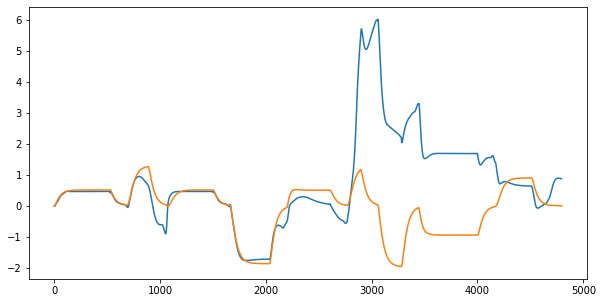

approximation_error: 143.7589805988386


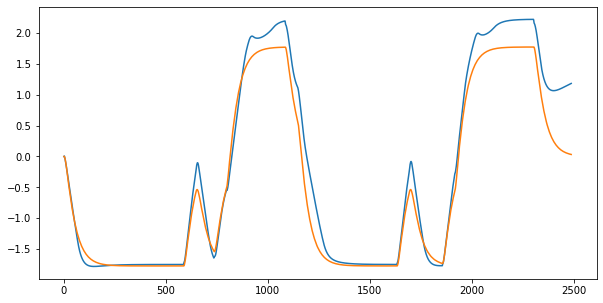

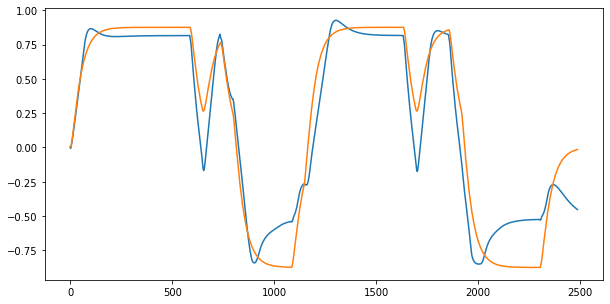

approximation_error: 607.9500012149873


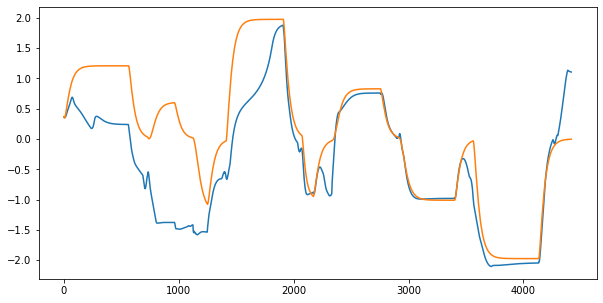

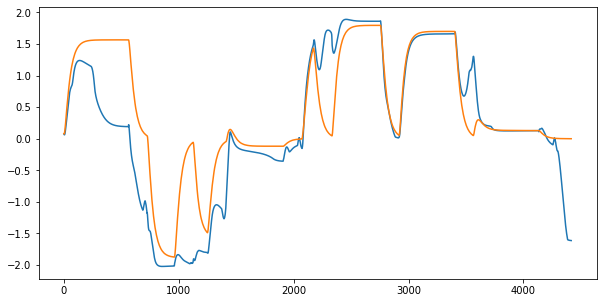

approximation_error: 50.56002356185482


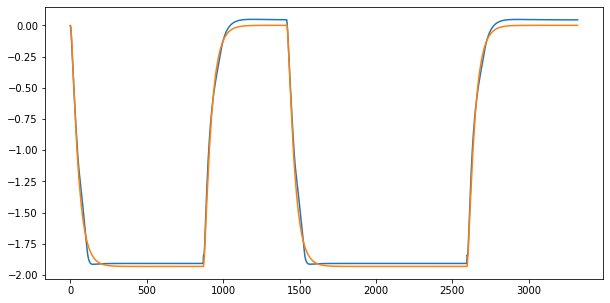

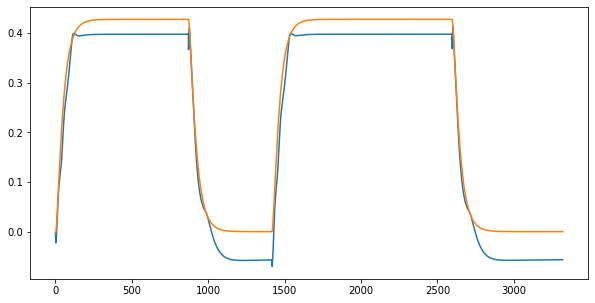

approximation_error: 1187.8906694751315


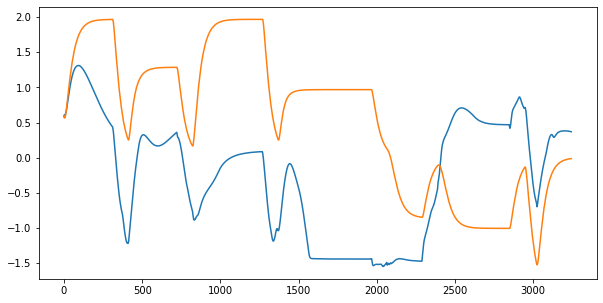

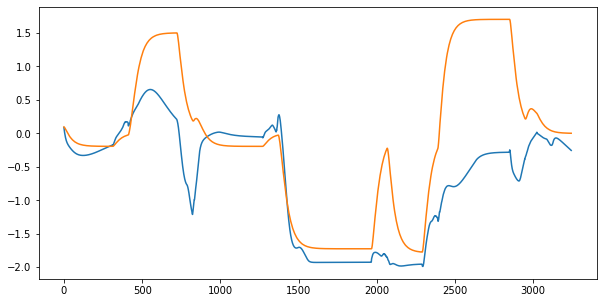

approximation_error: 157.94045338919247


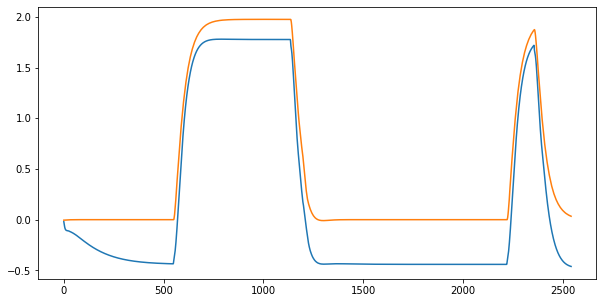

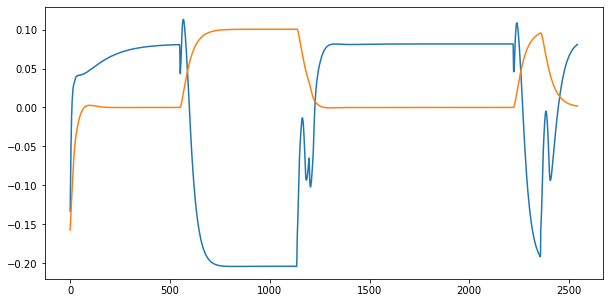

approximation_error: 105.50006204632882


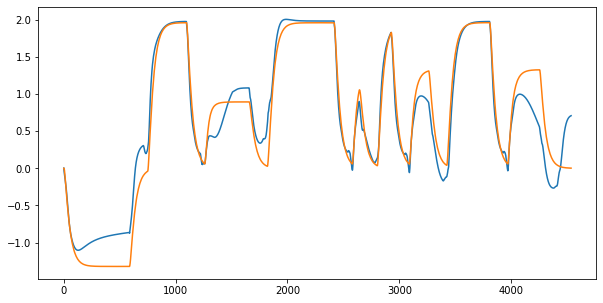

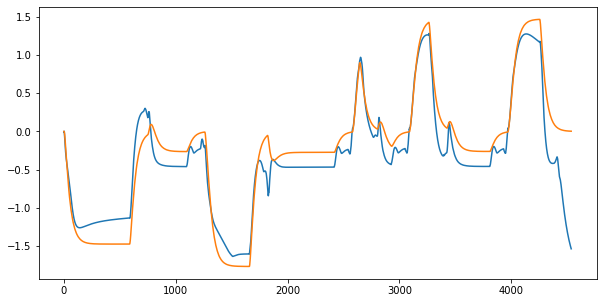

approximation_error: 653.1738365797368


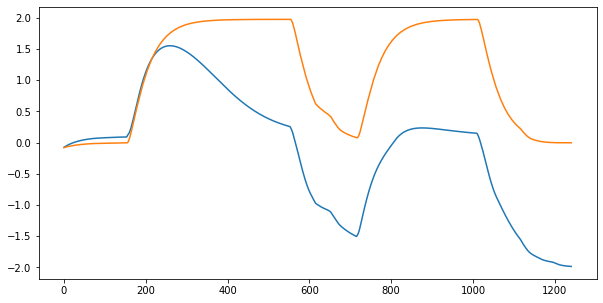

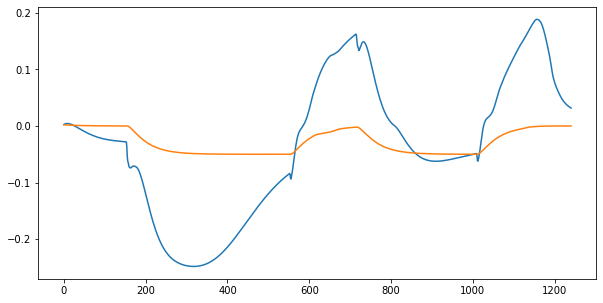

approximation_error: 22.356913091442156


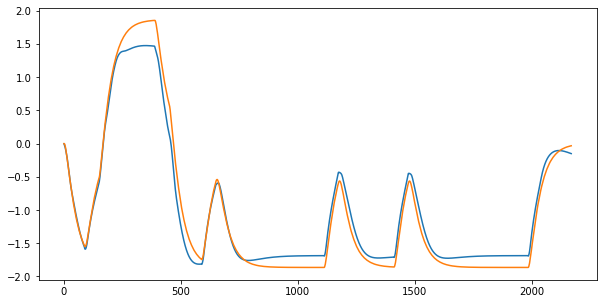

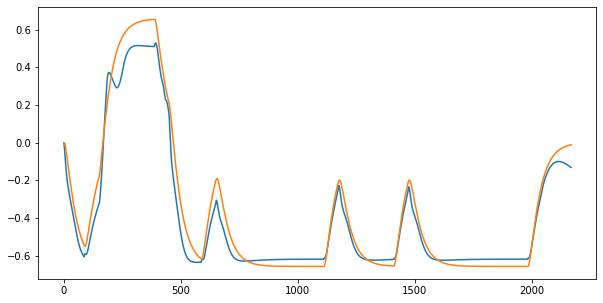

approximation_error: 95.04052005361947


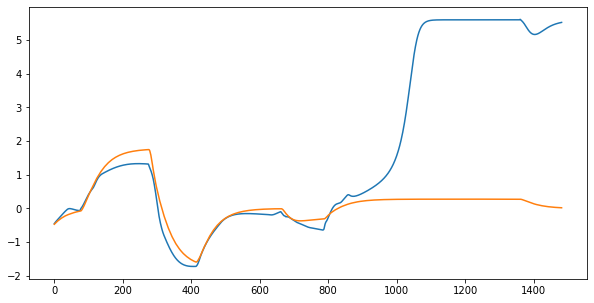

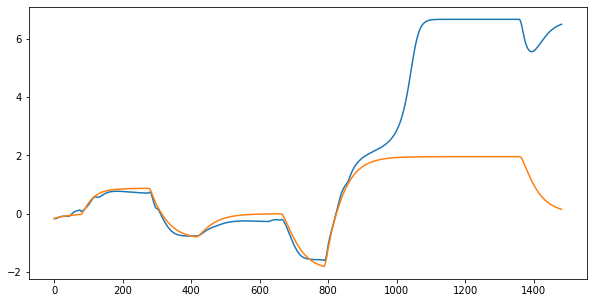

approximation_error: 250.02388965012213


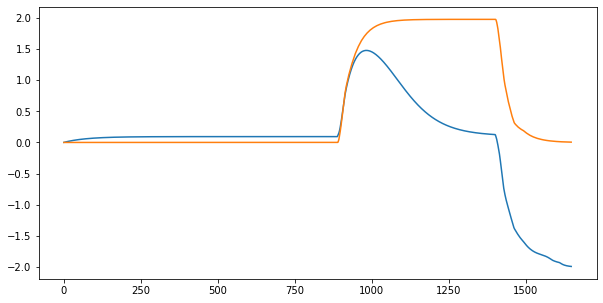

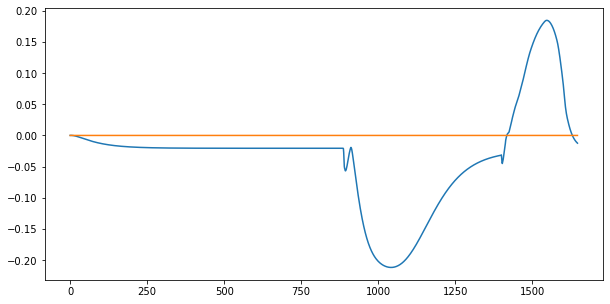

approximation_error: 393.5006265538465


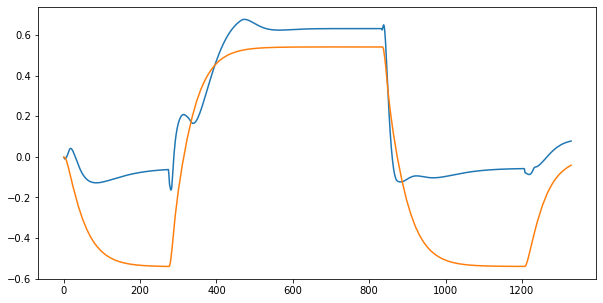

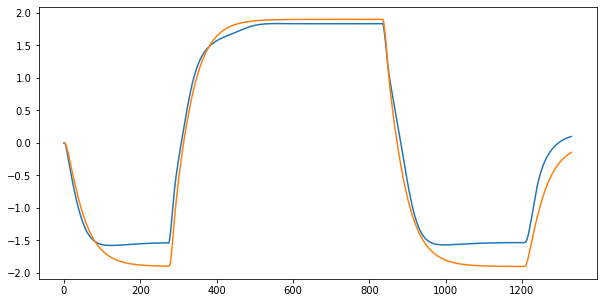

approximation_error: 57.71527730281083


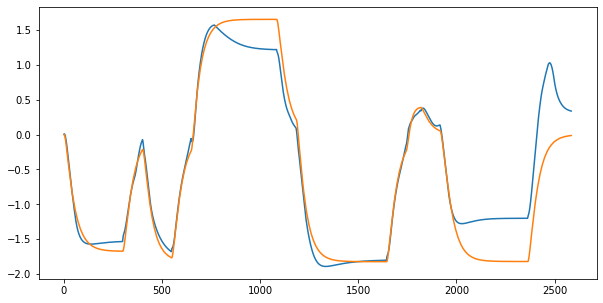

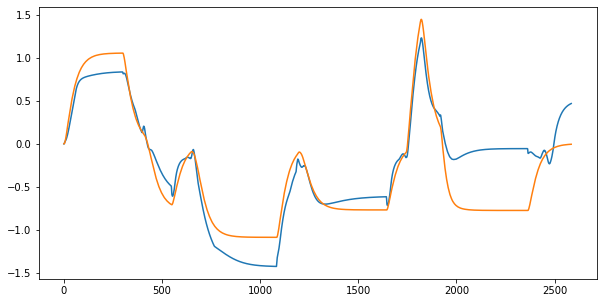

approximation_error: 1546.7964903284103


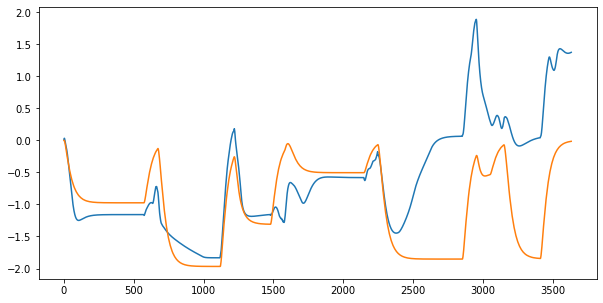

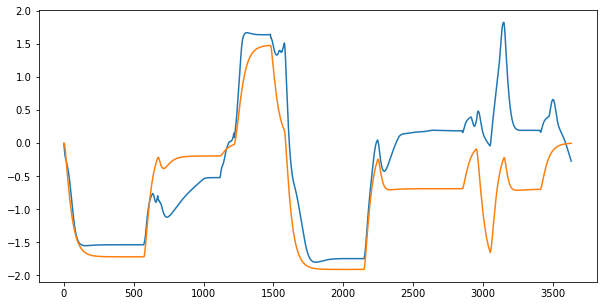

approximation_error: 968.817117740955


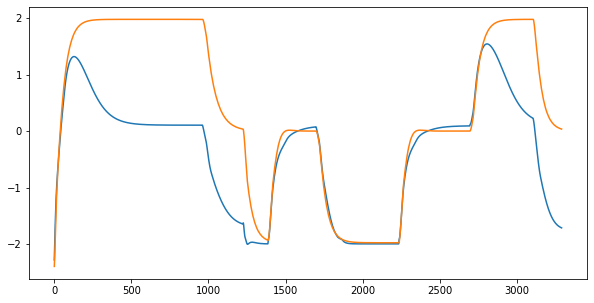

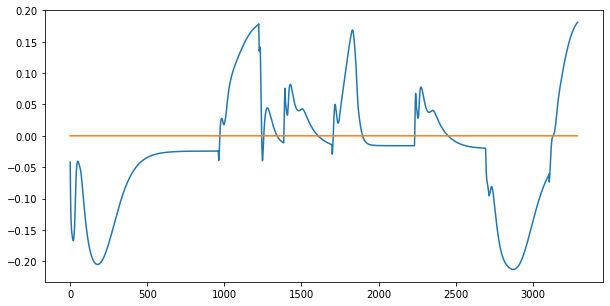

approximation_error: 771.5396575568693


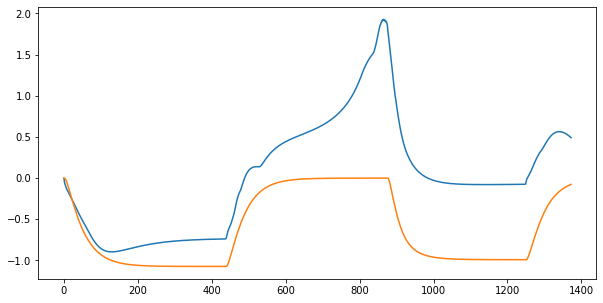

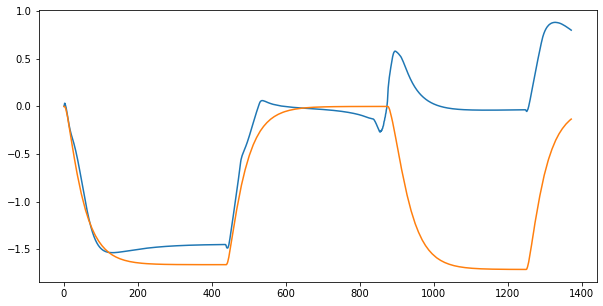

approximation_error: 180.9417496828416


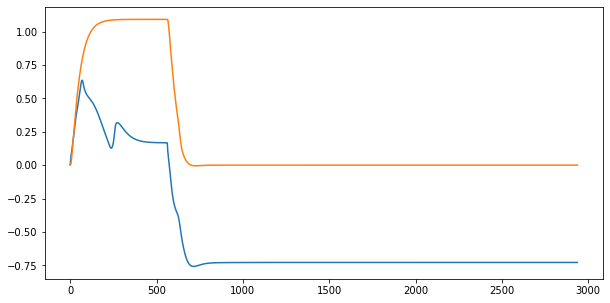

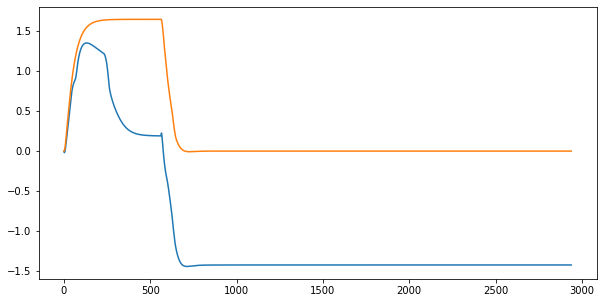

approximation_error: 182.8689797755509


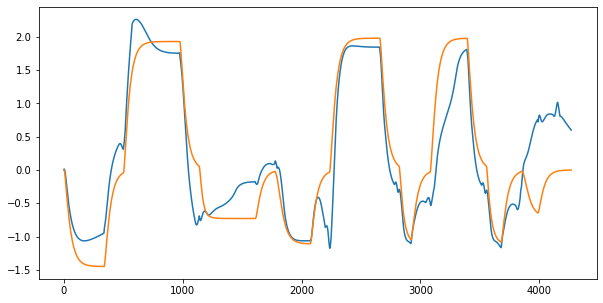

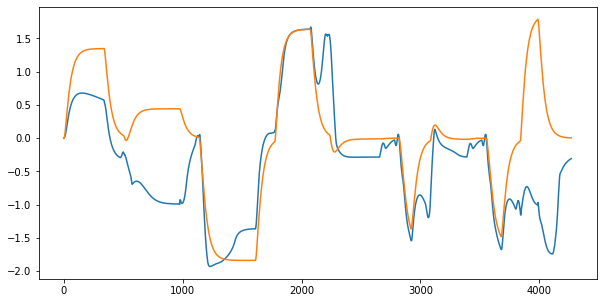

approximation_error: 495.4788854598636


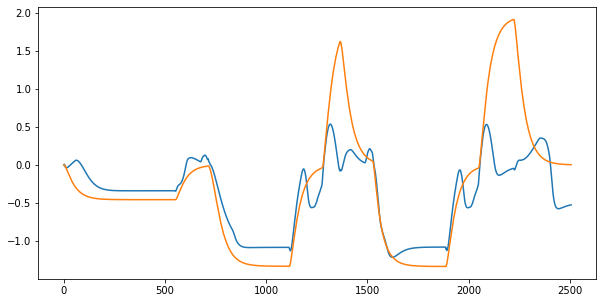

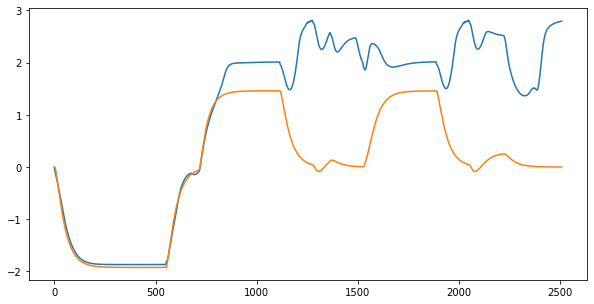

approximation_error: 17.67459421849518


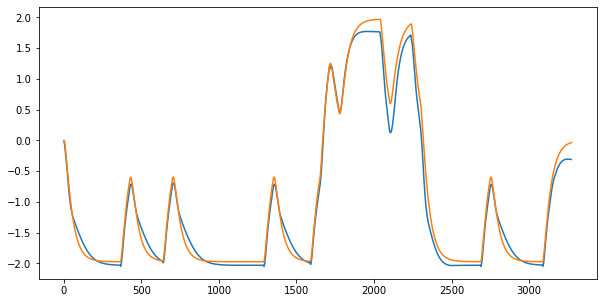

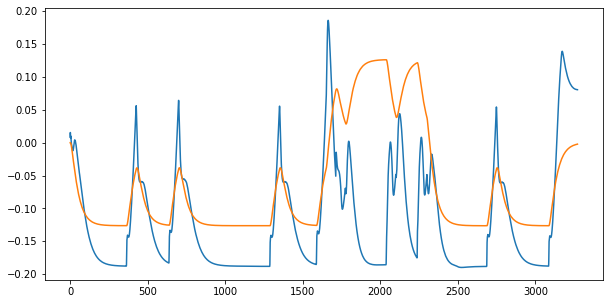

approximation_error: 526.4595918234234


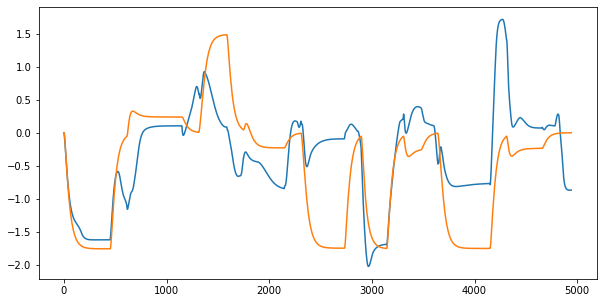

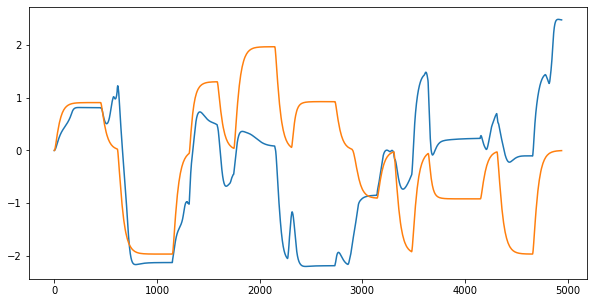

approximation_error: 35.615897084525756


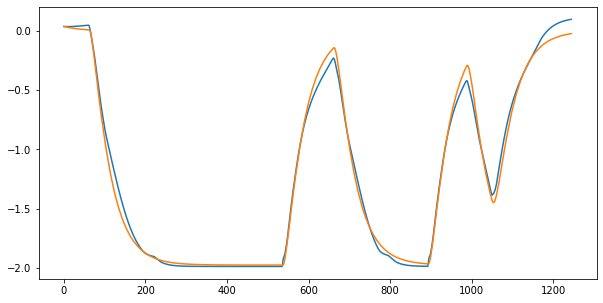

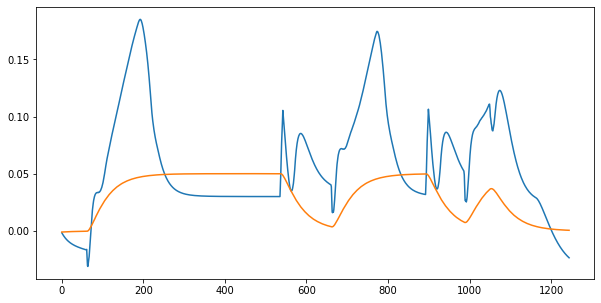

approximation_error: 47.83959926768821


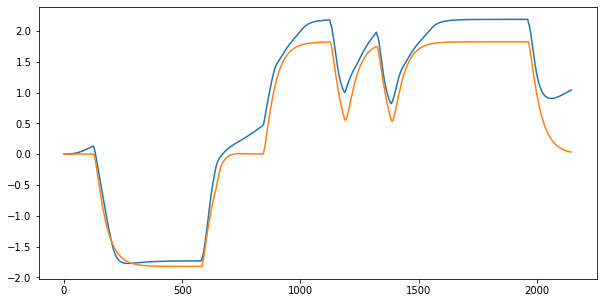

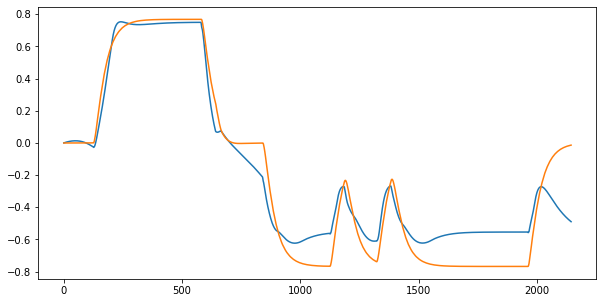

approximation_error: 222.5355406773703


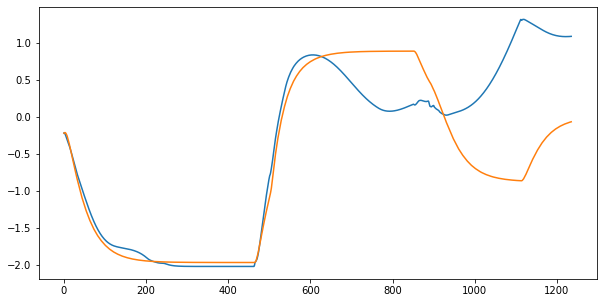

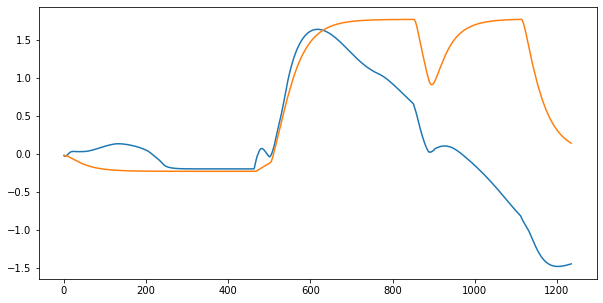

approximation_error: 148.37887994291378


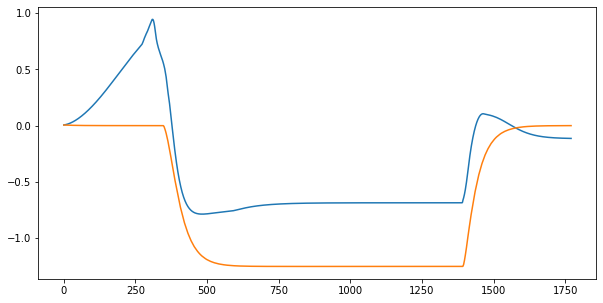

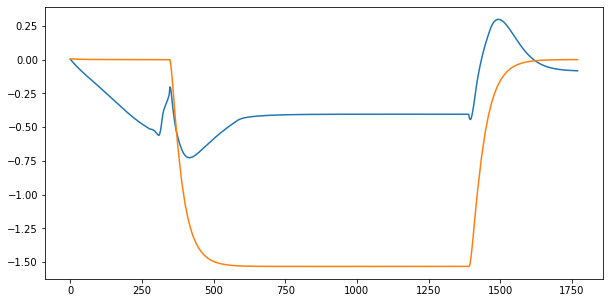

approximation_error: 950.5427730364962


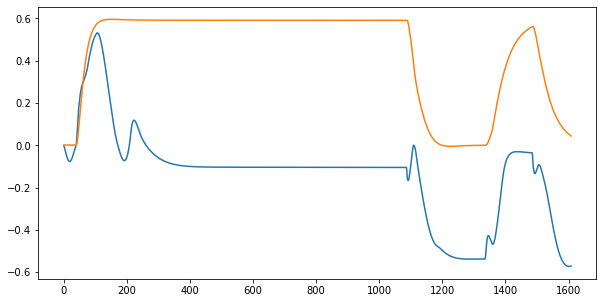

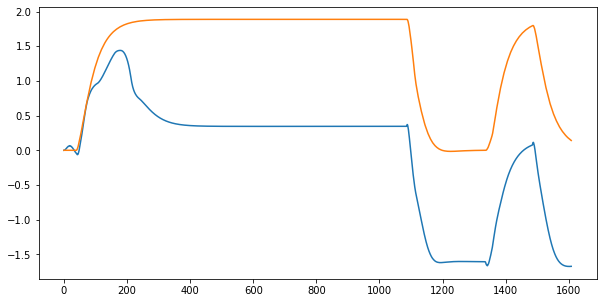

approximation_error: 85.10938530465943


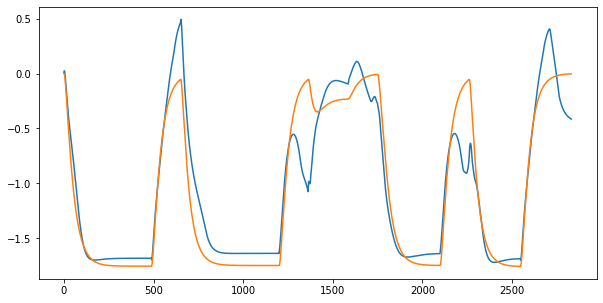

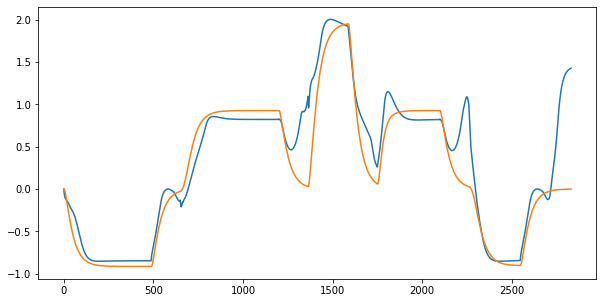

approximation_error: 182.57845069288248


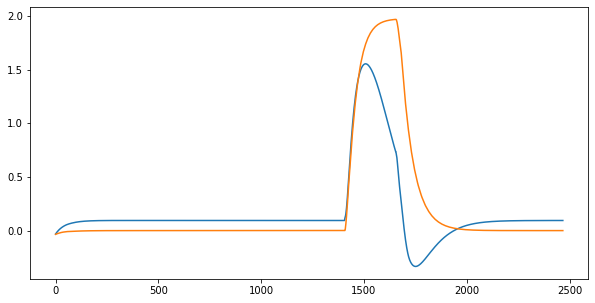

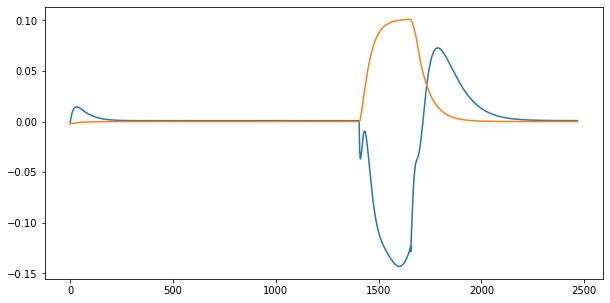

approximation_error: 356.55590872792754


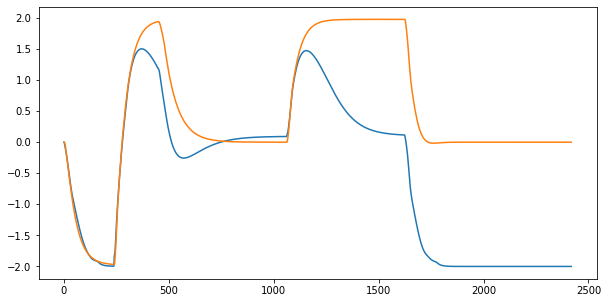

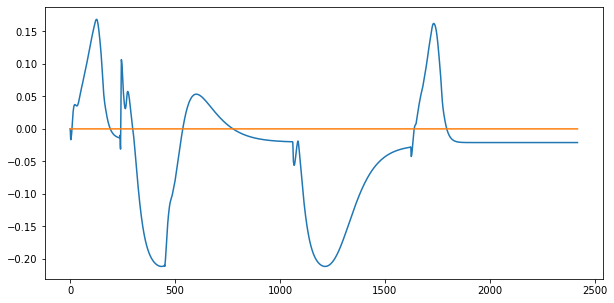

approximation_error: 86.14741719632221


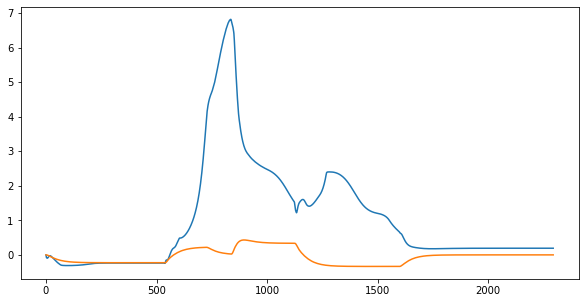

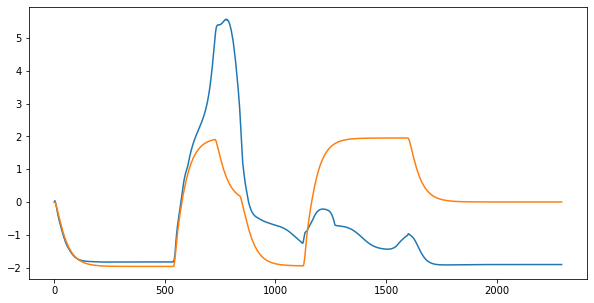

approximation_error: 363.9861669231663


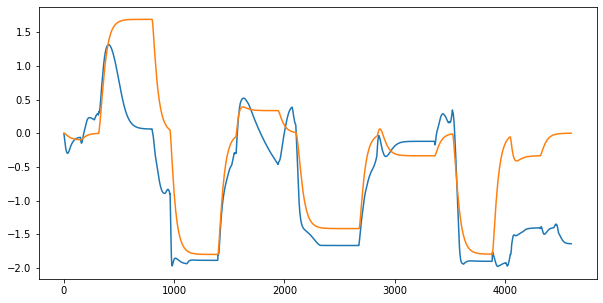

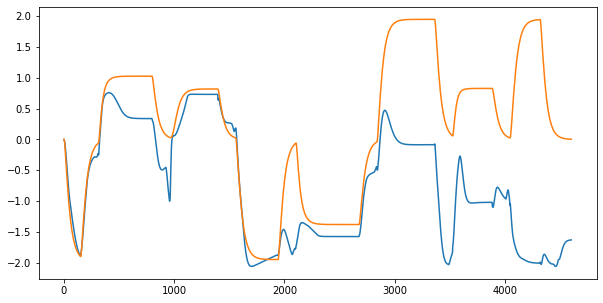

approximation_error: 189.70080294588158


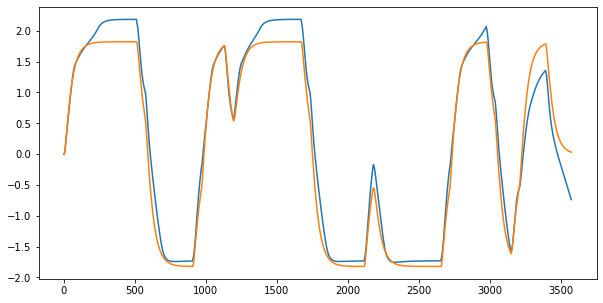

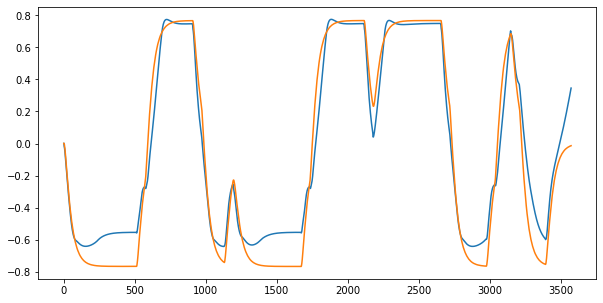

approximation_error: 1158.913501242105


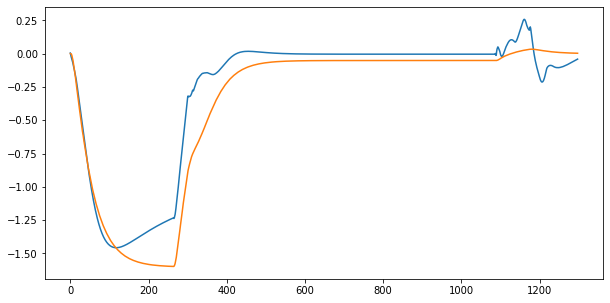

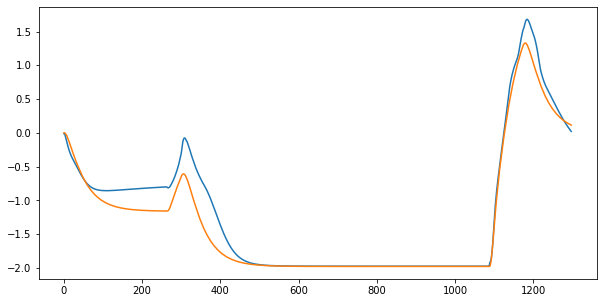

approximation_error: 57.9416226150814


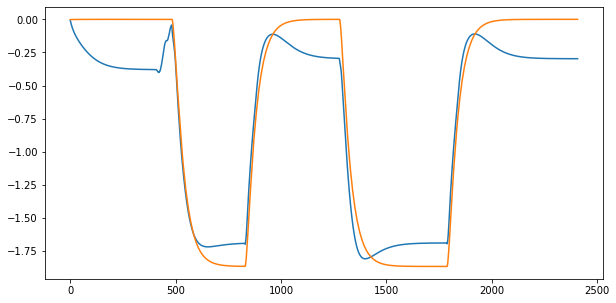

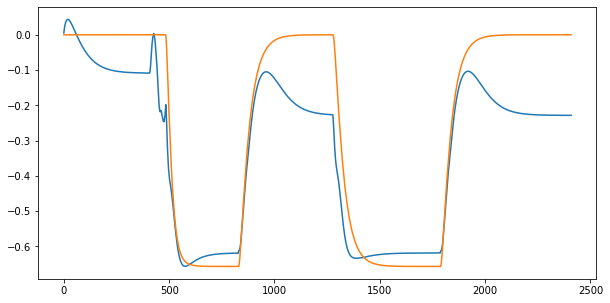

approximation_error: 252.66862965553196


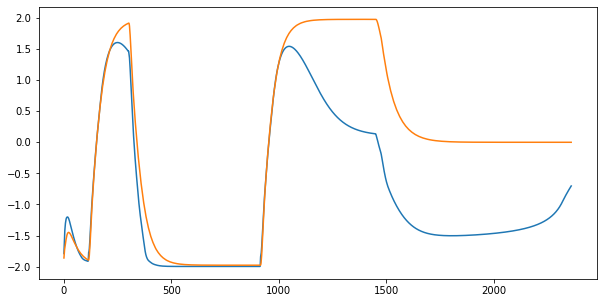

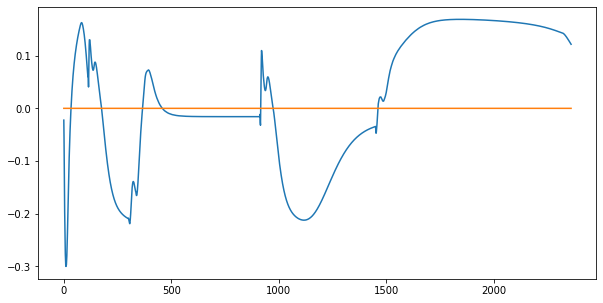

approximation_error: 189.32010481627137


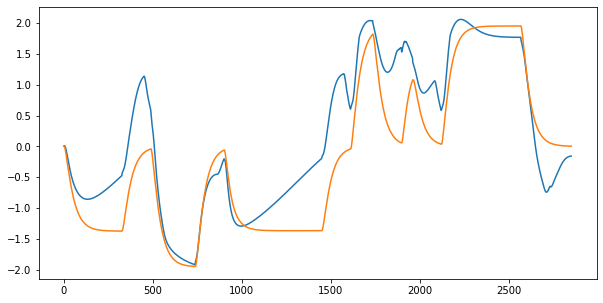

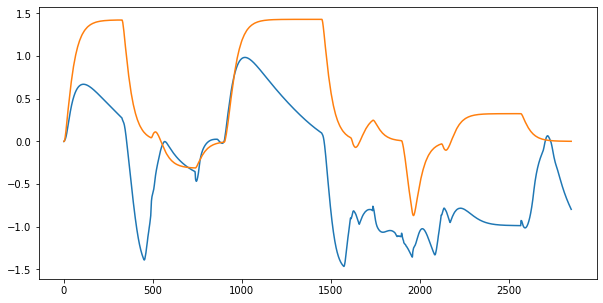

approximation_error: 180.94650502320988


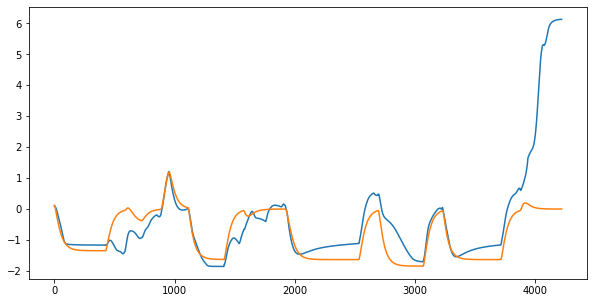

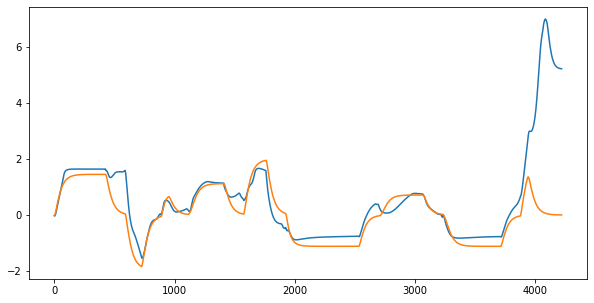

approximation_error: 57.35271636177036


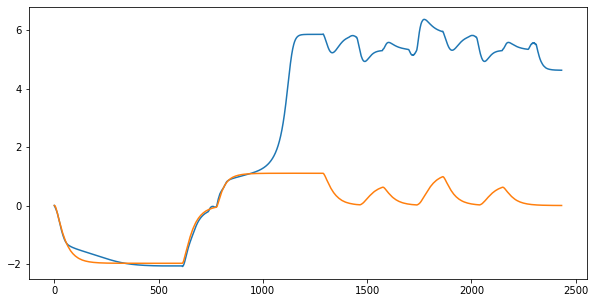

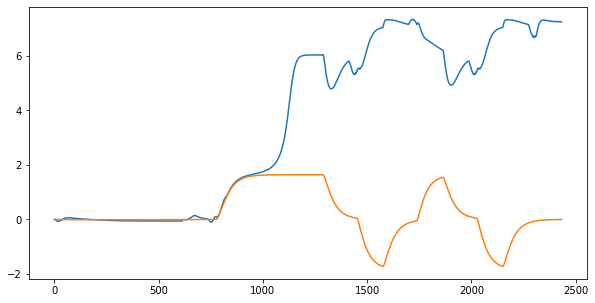

approximation_error: 144.83107020489422


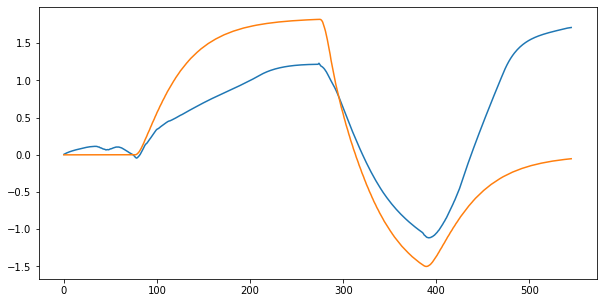

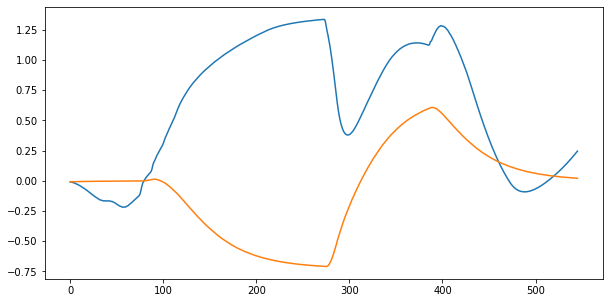

approximation_error: 400.25805487827705


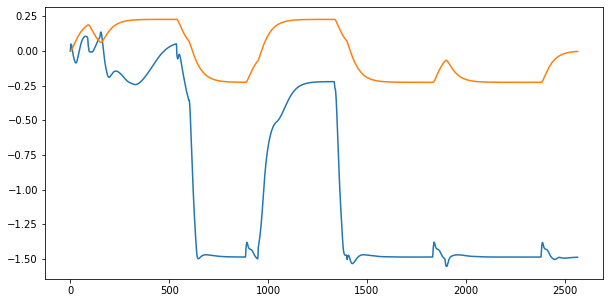

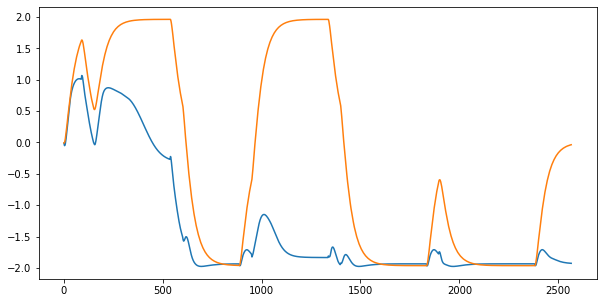

approximation_error: 343.5849562775173


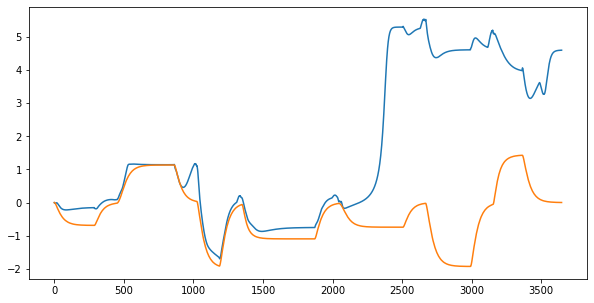

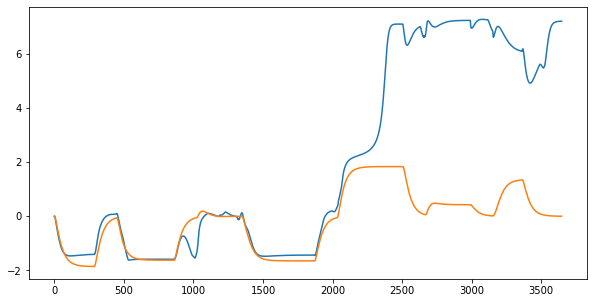

approximation_error: 85.73238141688078


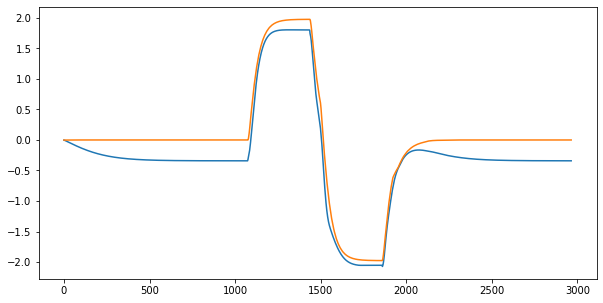

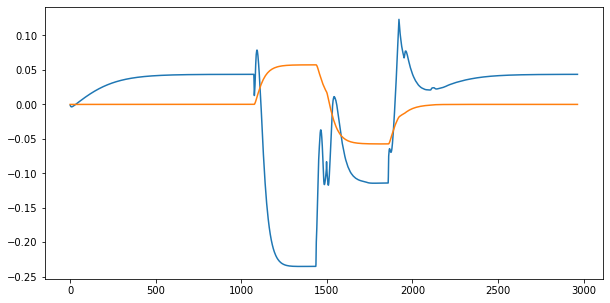

approximation_error: 307.7663139279696


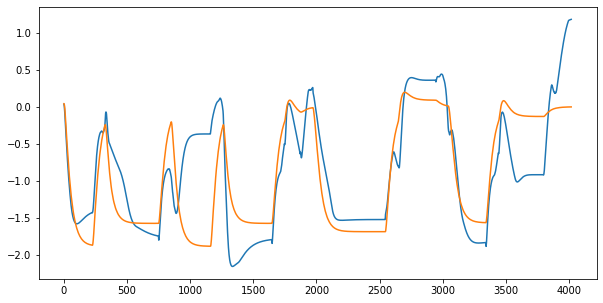

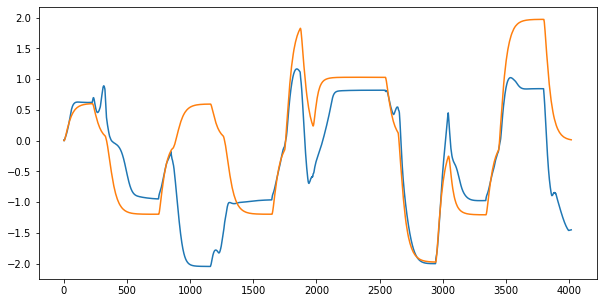

In [60]:
for record_file_name in get_recordings_files()[::2]:
  test_lstm_model_predictions(model, scaler_x, scaler_y, record_file_name) 

# Tests

In [ ]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_sequence_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

train_x = torch.Tensor(train_x) 
train_y = torch.Tensor(train_y) 
o2s_dataset = t_data.TensorDataset(train_x, train_y)
o2s_data_loader = t_data.DataLoader(o2s_dataset, batch_size=10, shuffle=True)

In [ ]:
x, y = next(iter(list(o2s_data_loader)))

In [ ]:
lstm = nn.LSTMCell( len(INPUT_SEQUENCE_COLUMNS),16)
for i in range(INPUT_SEQUENCE_LENGTH):
  x_new = x[:, i, :]
  h0, c0 = lstm(x_new)
  print(h0.shape)


In [ ]:
 lstm_out.shape

torch.Size([10, 20, 16])

In [ ]:
c0.shape

torch.Size([1, 10, 16])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

print(torch.__version__)
dataset = TensorDataset(torch.randn(100, 1), torch.randn(100, 1))
loader = DataLoader(dataset, batch_size=25, num_workers=2, persistent_workers=True)

for data, target in loader:
    print(data.shape)

1.11.0+cu102
torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1])
torch.Size([25, 1])


## Truning statistics

In [ ]:
# %load_ext tensorboard
# os.environ['TENSORBOARD_BINARY'] = '/home/israzex/Desktop/drone_homecoming_rl/venv/bin/tensorboard'
# %tensorboard --logdir "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/s2s_exp1_3/tensorboard"
